# 默认配置

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from waveforms import *
from scipy.signal import savgol_filter,correlate
# from scipy.signal import find_peaks
# from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import integrate

from pathlib import Path
import os
import time as TM

from quantum_driver.NS_MCI import Driver
DeviceIP = "192.168.1.193"



In [49]:
a = np.array([i+j for i in range(3) for j in range(8)])
a = np.hstack((a.reshape((24, 1)), a.reshape((24, 1)))).reshape(48).tolist()
print(a)

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


In [50]:
a =np.array(a)
b = a.reshape(3, 8, 2)
b[:, 1, :].reshape((3, 2))

array([[1, 1],
       [2, 2],
       [3, 3]])

In [2]:
def Pulse_wav(waveform = 'cos',envelope = 'cosPulse',samplerate = 2e9,freq = 201e6,time_len = 30e-9,width = 15e-9,repeat = 1,delay =0):
    
    time = np.linspace(0,time_len,int(time_len*samplerate))
    pulse = (eval(f'{waveform}')(2*np.pi*freq))*(eval(f'{envelope}')(width)>>time_len/2)

    wav = zero()
    for i in range(repeat):
        wav += pulse >> (width + delay)*i
    wav >>= 2e-9
    
    return time,wav


def filepath_generate():
    basepath = Path(os.getcwd())/'data'/f'{TM.localtime()[0]}'/(f'{TM.localtime()[1]}'+f'{TM.localtime()[2]}')
    if basepath.exists() is False:
        os.makedirs(basepath)
    return basepath

#  仪器测试

In [171]:
import time
import pyvisa as visa
import numpy as np

DPOAddress = "TCPIP::192.168.1.63"
rm = visa.ResourceManager()
dpo = rm.open_resource(DPOAddress)

def DSO90254A_readDOPChannel(dpo,
                   channel,
                   period=None,
                   returnTime=False,  #是否返回时间
                   sampleRate=20e9):
    # dpo.query(":STOP; *OPC?")
    # dpo.query(":ADER?")
    # dpo.write(":SINGle")
    dpo.write(f":WAVeform:SOURce CHAN{channel}")
    data = dpo.query(":WAVeform:DATA?")
    data = np.array([float(s) for s in data.split(',')[:-1]])
    if period is not None:
        periodPointNum = int(period * sampleRate)
        n = len(data) // periodPointNum
        data = data[:n * periodPointNum].reshape(n,
                                                 periodPointNum).mean(axis=0)
    if returnTime:
        return np.arange(len(data)) / sampleRate, data
    else:
        return data
    
readDOPChannel = DSO90254A_readDOPChannel  

print(dpo.query('*Idn?'))

Agilent Technologies,DSO90254A,MY51050119,03.21.0001



# DAC

## 波形生成

In [14]:
DArate = 6e9
ADrate = 4e9

time_len = 4000e-9
width = 4000e-9
freq = 100e6

shots = 10000


ADPointNumber = round(time_len*ADrate) 
DAPointNumber = round(time_len*DArate)
round(time_len*DArate)

24000

24000


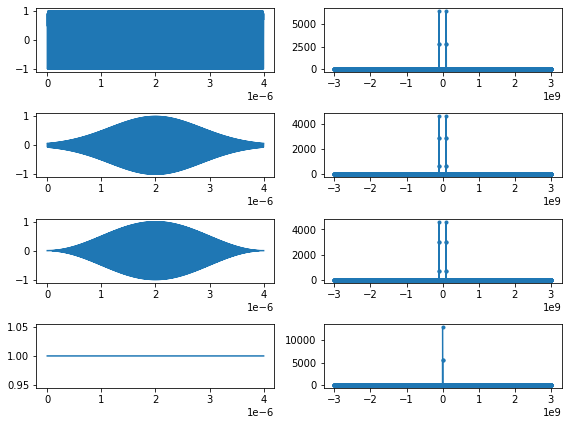

In [15]:

time = np.linspace(0,(DAPointNumber-1)/DArate, int(DAPointNumber))

wav1 = (cos(2*np.pi*freq))*(square(width,edge=2e-9)>>time_len/2)
wav2 = (cos(2*np.pi*freq))*(gaussian(width)>>time_len/2)
wav3 = (cos(2*np.pi*freq))*(cosPulse(width)>>time_len/2)

wav4 = (square(width)>>time_len/2)


print(len(wav1(time)))

fig,axs = plt.subplots(4,2,figsize=(8, 6))
# axs = axs.flatten()
for i in range(4):
    axs[i][0].plot(time,eval(f'wav{i+1}(time)'))
    fft_freq = np.fft.fftfreq(DAPointNumber,1/DArate)
    axs[i][1].plot(fft_freq,np.abs(np.fft.fft(np.hamming(DAPointNumber)*(eval(f'wav{i+1}(time)')))),'.-')
fig.tight_layout()

## 设备配置

### 实数波形

In [26]:
driver = Driver(DeviceIP)


sysparam = {
    'MixMode': 1, 'RefClock': 'in', 'DAC抽取倍数': 1, 'DAC本振频率':0
}

driver.open(system_parameter=sysparam)
driver.set('Shot', 1024000)


指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功
Shot 配置成功


In [28]:
#driver.set('Waveform', wav3(time), 8)  # 下发波形
driver.set('Waveform', wav3(time), 2)

#driver.set('LinSpace', (0, (DAPointNumber-1)/DArate ,DAPointNumber),6)
#driver.set('LinSpace', (0, (DAPointNumber-1)/DArate ,DAPointNumber),5)

#driver.set('GenWave', wav3, 9)    # 波形函数生成
#driver.set('GenWave', wav3, 5)



driver.set('Shot', shots)
#driver.set('GenerateTrig',  1e7)


Waveform 配置成功
Shot 配置成功


In [10]:
%matplotlib notebook

yc1 = []
yc3 = []

for i in range(5):
    t, y1 = readDOPChannel(dpo, 1,returnTime=True, sampleRate=320e9)
    t, y3 = readDOPChannel(dpo, 3,returnTime=True, sampleRate=320e9)

    yc1.append(y1)
    yc3.append(y3)


yr1 =  np.mean(yc1,axis=0)
yr3 =  np.mean(yc3,axis=0)

yr1.shape
plt.figure()
plt.plot(t/1E-9, yr1)
plt.plot(t/1E-9, yr3, alpha=0.4)

NameError: name 'readDOPChannel' is not defined

### 复数波形

In [11]:
%matplotlib notebook


NCOfreq = 1.1e9
Ratio = 8


pulse = cosPulse(width)


x_wav = zero()
y_wav = zero()

I, Q = mixing(pulse>>time_len/2,freq=freq-NCOfreq)
x_wav += I
y_wav += Q

dout = x_wav*cos(2*np.pi*NCOfreq) + y_wav*sin(2*np.pi*NCOfreq)

"""
I, Q = mixing(pulse1 >> 50e-9, freq=freq, phase=np.pi/2)
x_wav += I
y_wav += Q


I, Q = mixing((0.5 * pulse) >> 2e-6, freq=freq, DRAGScaling=0.2)
x_wav += I
y_wav += Q
"""

tm = np.linspace(0,(DAPointNumber-1)/DArate, DAPointNumber)
tmratio = np.linspace(0,(DAPointNumber-1)/DArate, DAPointNumber//Ratio)


plt.plot(tmratio, x_wav(tmratio))
plt.plot(tmratio, y_wav(tmratio),alpha = 0.4)

#plt.plot(tm, dout(tm))
#plt.plot(tm, wav3(tm),alpha = 0.4)
plt.show()

<IPython.core.display.Javascript object>

In [7]:
driver = Driver(DeviceIP)

sysparam = {
    'MixMode': 1, 'RefClock': 'in', 'DAC抽取倍数': Ratio, 'DAC本振频率': NCOfreq/1e6
}

driver.open(system_parameter=sysparam)


NameError: name 'Ratio' is not defined

In [106]:
tmratio.shape

(24,)

In [118]:
driver.set('Waveform', wav3(time), 8)  # 下发波形
driver.set('Waveform', wav4(time), 7)

driver.set('LinSpace', (0, (DAPointNumber-1)/DArate ,int(DAPointNumber//Ratio)),5)

driver.set('GenWaveIQ', (y_wav, x_wav), 5)



driver.set('Shot', shots)
driver.set('GenerateTrig',  1e7)

Waveform 配置成功
Waveform 配置成功
LinSpace 配置成功
GenWaveIQ 配置成功
Shot 配置成功
GenerateTrig 配置成功


### DPO获取分析

<IPython.core.display.Javascript object>


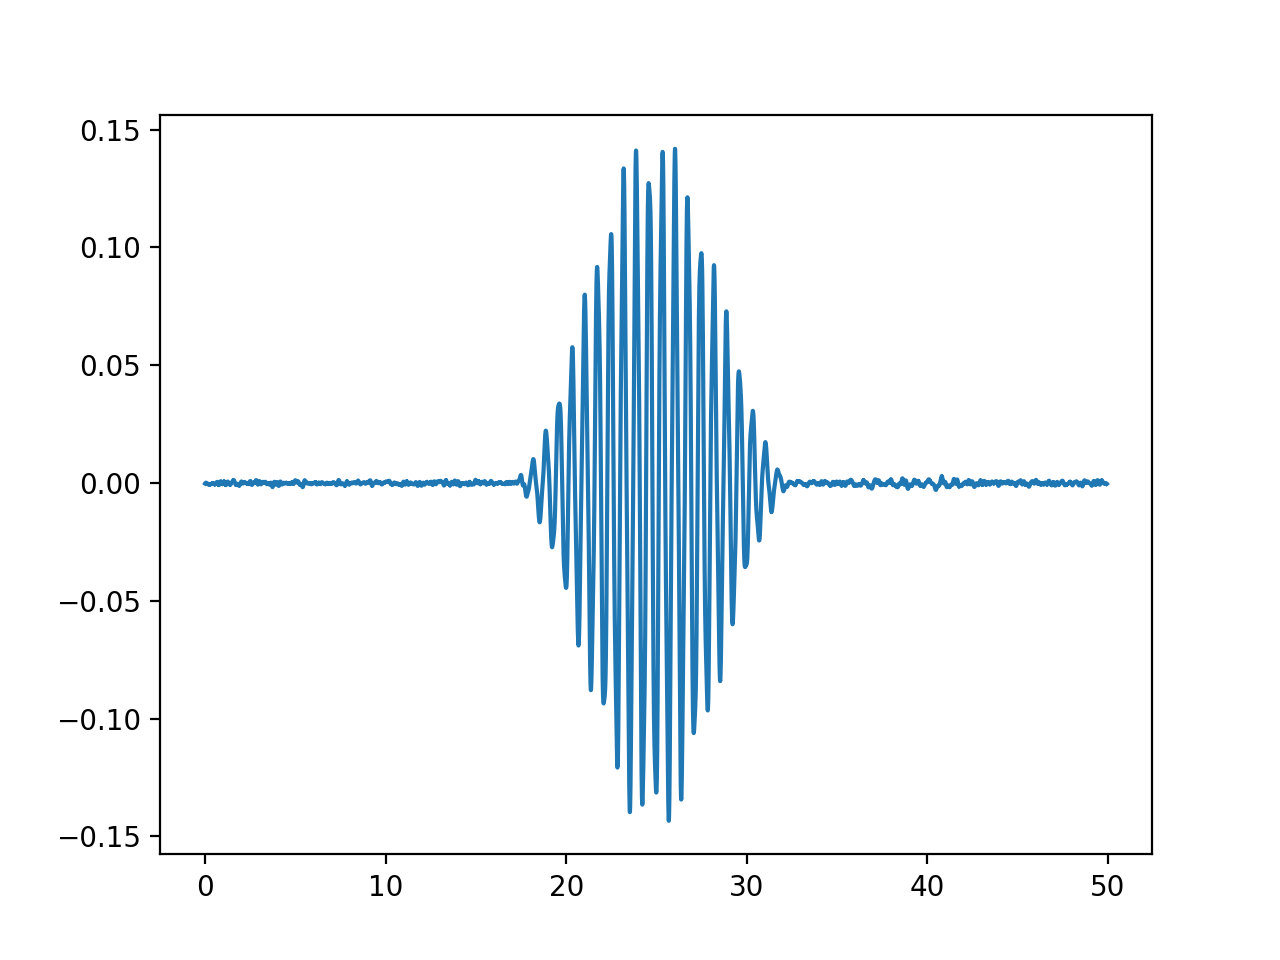

In [152]:
yc = []
for i in range(5):
    t, y1 = readDOPChannel(dpo, 1, returnTime=True, sampleRate=320e9)
    yc.append(y1)

yc =  np.mean(yc,axis=0)
yc.shape
plt.figure()
plt.plot(t/1E-9, yc)

In [153]:
time,wav = Pulse_wav(samplerate = 6e9,freq = 1400e6, time_len = 16e-9,width = 16e-9,repeat = 1)
wav = (wav+1)/2

<IPython.core.display.Javascript object>


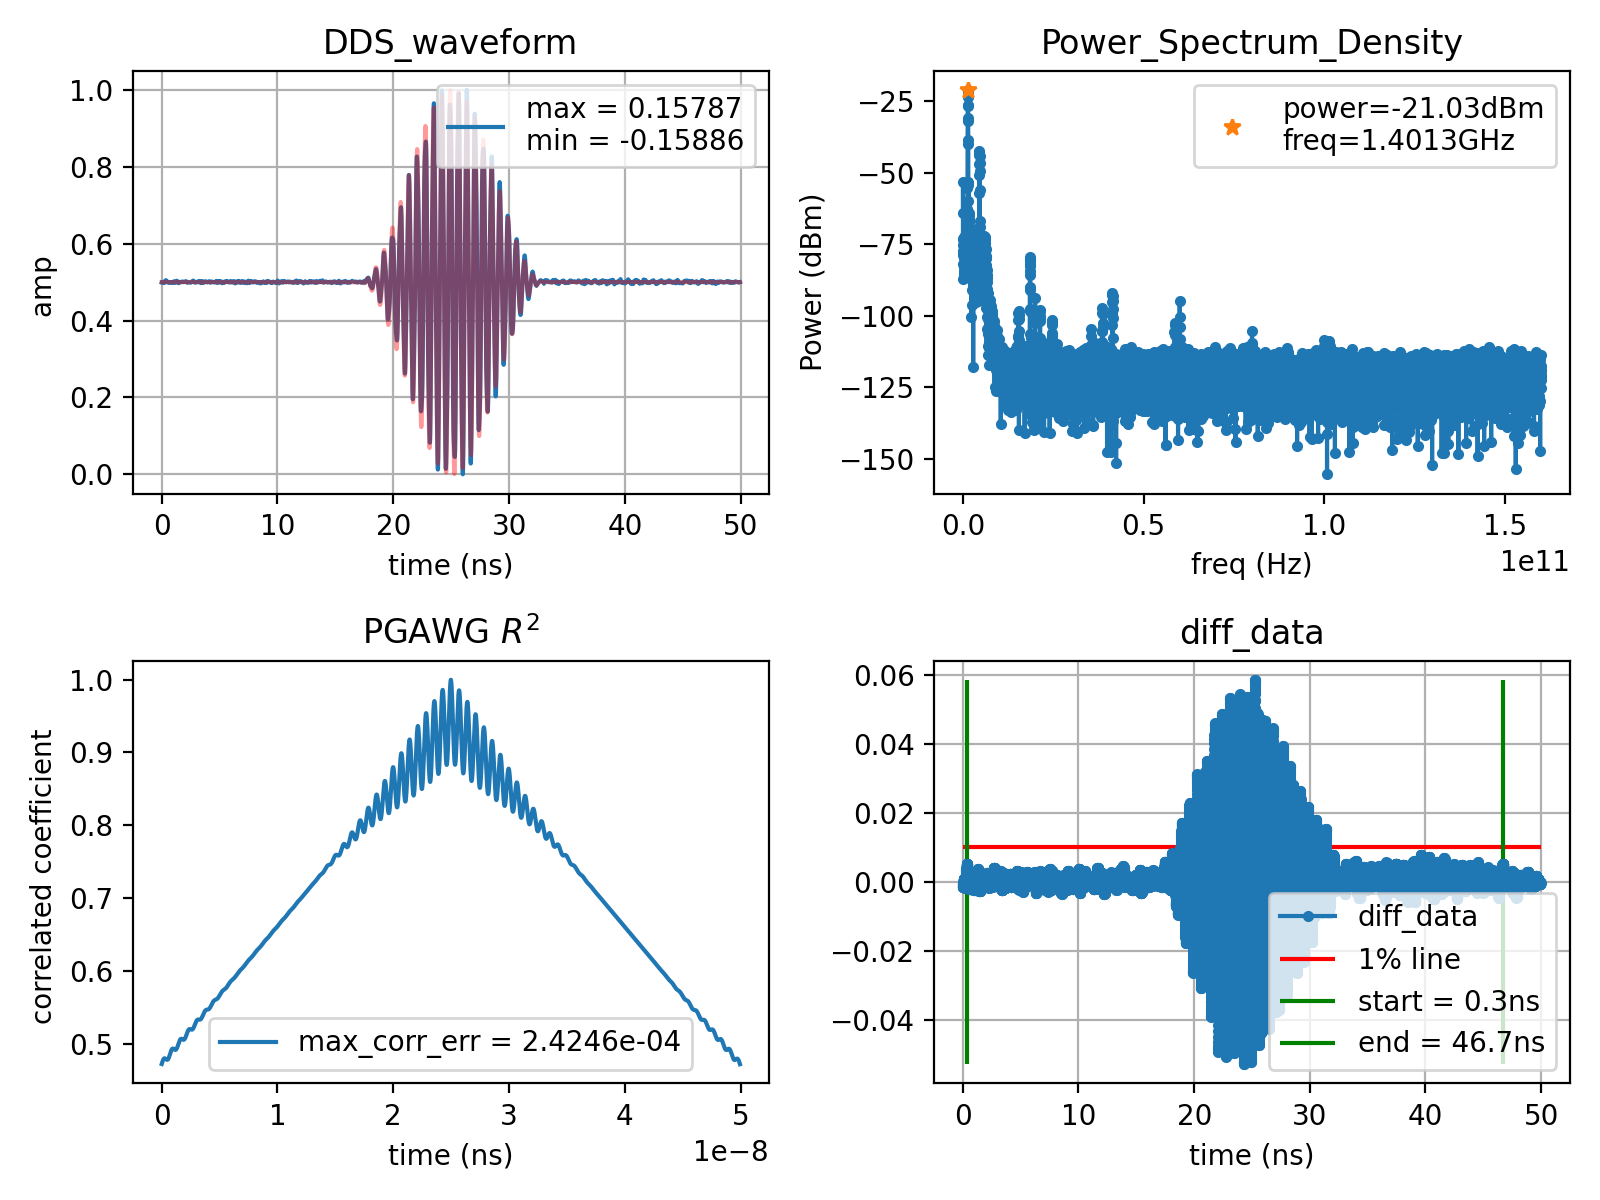

In [155]:
%matplotlib notebook
y = yr3
plt.figure(figsize=(8, 6))
plt.subplot(221)
ch = 8
maxValue = np.max(y)
minValue = np.min(y)
normlized_y = (y - minValue) / (maxValue - minValue)

plt.plot(t / 1e-9,
         normlized_y,
         label=f'max = {maxValue:.5f}\nmin = {minValue:.5f}')
plt.title('DDS_waveform')
plt.xlabel('time (ns)')
plt.ylabel('amp ')
plt.legend(loc=1)
plt.grid(visible=True, which='both', axis='both')

# plt.plot(t / 1e-9,wav(t),'-g',alpha = 0.4,label='origin')
temp = correlate(wav(t),normlized_y,mode='same',method='fft')
temp1 = [np.correlate((wav>>temp_t)(t),normlized_y) for temp_t in t]
align_t2 = t[np.argmax(temp1)]

# func = interp1d(np.arange(len(t)),temp,kind='cubic')
# smooth_t = np.linspace(0,len(t)-1,20001)
# smooth_y = savgol_filter(func(smooth_t),window_length=41, polyorder=3)

# align_t = t[int(smooth_t[np.argmax(smooth_y)])]-2*9.5e-9
# print(0.5*(t[0]+t[-1]))

new_wav = wav >> align_t2
#new_wav = wav >> 16e-9
plt.plot(t / 1e-9,new_wav(t),'-r',alpha = 0.4,label='align')
plt.show()
# plt.legend()

data_corr = correlate(new_wav(t),normlized_y,mode='same',method='fft')
data_corr /= np.sqrt(
    np.correlate(normlized_y, normlized_y)[0] *
    np.correlate(new_wav(t), new_wav(t))[0])
max_corr = np.max(data_corr)

plt.subplot(222)
f = interp1d(t,y**2/50,kind='linear')
value,_ = integrate.quad(f,t[0],t[-1])
freq = np.fft.fftfreq(len(t),t[1]-t[0])[:len(t)//2]
data = np.fft.fft(np.correlate(y,y,'same'))[:len(t)//2]

data = np.fft.fft(y)[:len(t)//2]
data = np.abs(data)**2/50
data = value*30e6*data/np.sum(data)
power = 10*np.log10(data/1e-3)

peak_freq = freq[np.argmax(power)]
peak_power = np.max(power)
plt.plot(freq,power,'.-')
plt.plot(peak_freq,peak_power,'*',label = f'power={peak_power:.2f}dBm\nfreq={peak_freq/1e9:.4f}GHz')
plt.title('Power_Spectrum_Density')
plt.xlabel('freq (Hz)')
plt.ylabel('Power (dBm)')
plt.legend()


plt.subplot(223)
plt.plot(t,data_corr,'-',label =f'max_corr_err = {1-max_corr:.4e}')
plt.title('PGAWG $R^2$')
plt.xlabel('time (ns)')
plt.ylabel('correlated coefficient ')
plt.legend()




plt.subplot(224)
diff_data =  normlized_y - new_wav(t)

plt.plot(t/1e-9,diff_data,'.-',label='diff_data')
plt.hlines(0.01,0,50,colors="red",label='1% line')
start_time = np.where(np.abs(diff_data)>=0.005)[0][0]
end_time = np.where(np.abs(diff_data)>=0.005)[0][-1]
plt.vlines(t[start_time]/1e-9,np.min(diff_data),np.max(diff_data),colors="green",label=f'start = {t[start_time]/1e-9:.1f}ns')
plt.vlines(t[end_time]/1e-9,np.min(diff_data),np.max(diff_data),colors="green",label=f'end = {t[end_time]/1e-9:.1f}ns')
plt.title('diff_data')
plt.xlabel('time (ns)')
plt.grid(visible=True, which='both', axis='both')
plt.legend(loc=4)
plt.show()
plt.tight_layout()

basepath = filepath_generate()
plt.savefig(basepath / f'RFsoc_DDS_cos_ch{ch}_{int(TM.time())}')
np.savez(basepath / f'RFsoc_DDS_cos_ch{ch}_{int(TM.time())}',
         t=t,
         data=y,
         waveform=new_wav)

# ADC

## 波形生成及处理

In [3]:
def coff_para(t=[],freq=200e6):
    coeff_list_I = np.array(cos(2*np.pi*(freq))(t))
    coeff_list_Q = np.array(sin(2*np.pi*(freq))(t))
    return coeff_list_I+1j*coeff_list_Q

def getTraceIQ(y,coff_para=np.asarray([])):
    return  np.abs(y).dot(coff_para.T)/len(y)


In [4]:
freqlist = [100e6]

ADrate = 4e9
DArate = 6e9

time_len = 4.096e-6

ADPointNumber = round(4e-6*ADrate)
DAPointNumber = round(time_len*DArate)
print('AD', ADPointNumber)
print('DA', DAPointNumber)
shots = 1000

for i in range(len(freqlist)):
    if i:
        wavs = cos(2*np.pi*(freqlist[i])) + wavs
    else:
        wavs = (square(time_len)>>4e-6) * cos(2*np.pi*(freqlist[i]))
               
wavs = wavs/len(freqlist)
da = np.zeros(DAPointNumber)

tm = np.linspace(0,(DAPointNumber-1)/DArate, int(DAPointNumber))

AD 16000
DA 24576


In [5]:
%matplotlib notebook

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(tm, wavs(tm))
plt.show()

plt.subplot(212)
fq = np.fft.fftfreq(DAPointNumber,1/DArate)
plt.plot(fq, np.abs(np.fft.fft(wavs(tm))))
plt.show()

<IPython.core.display.Javascript object>

## ADC配置

In [6]:
driver = Driver(DeviceIP)


sysparam = {
    'MixMode': 2, 'RefClock': 'in', 'DAC抽取倍数': 1, 'DAC本振频率':0
}

driver.open(system_parameter=sysparam)


指令初始化执行失败
指令DAC配置执行失败
指令ADC配置执行失败


ConnectionRefusedError: [WinError 10061] 由于目标计算机积极拒绝，无法连接。

In [159]:
driver.set('PointNumber', ADPointNumber)
driver.set('Shot', shots)

for i in range(8):
    driver.set('TriggerDelay', 0, i+1)
        
driver.set('FrequencyList', freqlist,9)
# driver.set('TriggerDelay', 855, 9)

# driver.set('LinSpace', (0, (DAPointNumber-1)/DArate ,DAPointNumber),9)
wavs.start = 0
wavs.stop = (DAPointNumber-1)/DArate
# driver.set('GenWave', wavs, 9)    # 波形函数生成
value = wavs(np.linspace(0, (DAPointNumber-1)/DArate ,DAPointNumber))
driver.set('Waveform', value, 9)

PointNumber 配置成功
Shot 配置成功
TriggerDelay 配置成功
TriggerDelay 配置成功
TriggerDelay 配置成功
TriggerDelay 配置成功
TriggerDelay 配置成功
TriggerDelay 配置成功
TriggerDelay 配置成功
TriggerDelay 配置成功
FrequencyList 配置成功
Waveform 配置成功


%timeit driver.set('Waveform', value, 1)

In [160]:
driver.set('StartCapture')  # 启动指令

#driver.set('GenerateTrig',  200e3)

StartCapture 配置成功


In [163]:
driver.set('GenerateTrig',  200e3)

GenerateTrig 配置成功


In [164]:
%matplotlib notebook

tmp = driver.get('TraceIQ', channel=8)
tmp.shape

(1000, 16000)

In [165]:
pic = tmp[0]
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(pic)
plt.show()

plt.subplot(212)
fq = np.fft.fftfreq(int(len(pic)),1/ADrate)
plt.plot(fq, np.abs(np.fft.fft(pic)))
plt.show()

<IPython.core.display.Javascript object>

In [166]:
start = TM.time()
tmp2 = driver.get('IQ',channel=1)
print(TM.time()- start)
tmp2 = np.swapaxes(tmp2,0,1)
tmp2.shape


0.05399918556213379


(1, 1000)

In [48]:
%timeit tmp2 = driver.get('IQ', channel=1)

77.2 ms ± 5.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
plt.figure(figsize=(8,6))
plt.subplot(121)

#plt.plot(np.real(tmp[0]),np.imag(tmp[0]), '.', color = 'r')
plt.plot(np.real(tmp2[0]),np.imag(tmp2[0]), '.', color = 'b')

plt.show()
plt.subplot(122)

#plt.plot(np.real(tmp[1]),np.imag(tmp[1]), '.', color = 'r')
plt.plot(np.real(tmp2[1]),np.imag(tmp2[1]), '.', color = 'b')
plt.show()


# #sl新增
# plt.figure(figsize=(8,6))
# plt.subplot(211)
# plt.plot(20*np.log10(np.abs(tmp2[0])), color = 'b')
# plt.show()
# plt.subplot(212)
# plt.plot(np.angle(tmp2[0],True), color = 'b')
# plt.show()
#
# plt.figure(figsize=(8,6))
# plt.subplot(211)
# plt.plot(20*np.log10(np.abs(tmp2)).T)
# plt.show()
# plt.subplot(212)
# plt.plot(np.angle(tmp2,True).T)
# plt.show()

<IPython.core.display.Javascript object>

# 设备复位

In [ ]:
# driver.set('Reset',0)

In [ ]:
# driver.close()

In [8]:
import pickle

In [9]:
value = wavs(np.linspace(0, (DAPointNumber-1)/DArate ,DAPointNumber))
value.shape

(600000,)

In [10]:
from quantum_driver.NS_MCI import RPCValueParser

In [159]:
%timeit a = pickle.dumps(RPCValueParser.dump(value))
a = pickle.dumps(RPCValueParser.dump(value))

2.89 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [160]:
%timeit b = RPCValueParser.load(pickle.loads(a))

906 µs ± 130 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [182]:
c = memoryview(value)
d = value.tobytes()

In [11]:
import socket
def connect_test():
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.connect(('192.168.1.195', 10800))
    sock.setsockopt(socket.SOL_SOCKET, socket.SO_KEEPALIVE, True)
    sock.ioctl(socket.SIO_KEEPALIVE_VALS, (1, 60*1000, 30*1000))
    # sock.close()
    return sock

In [141]:
%timeit connect_test()

2.86 ms ± 713 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
sock = connect_test()

In [31]:
import struct
value = wavs(np.linspace(0, (DAPointNumber-1)/DArate ,DAPointNumber))
_value = RPCValueParser.dump(value)
a = pickle.dumps(('Waveform', _value, 1))

In [43]:
head = struct.pack('=IIII', *[0x5F5F5F5F, 0x32000001, 0, 16+len(a)])

In [44]:
sock.sendall(head)
sock.sendall(a)

In [45]:
head = struct.unpack("=IIIII", sock.recv(20))


(3486502863, 838860801, 0, 24, 0)

In [46]:
data = sock.recv(head[3]-20)

In [47]:
pickle.loads(data)

True

In [48]:
sock.close()

In [32]:
def sends(channel):
    sock = connect_test()
    a = pickle.dumps(('Waveform', _value, channel))
    head = struct.pack('=IIII', *[0x5F5F5F5F, 0x32000001, 0, 16+len(a)])
    sock.sendall(head)
    sock.sendall(a)
    head = struct.unpack("=IIIII", sock.recv(20))
    data = sock.recv(head[3]-20)
    sock.close()
    return pickle.loads(data)

In [33]:
sends(1)

True

In [26]:
def aaaa():
    for i in range(1, 9):
        sends(i)

In [27]:
aaaa()

In [34]:
%timeit aaaa()

5.01 s ± 873 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
